In [5]:
import os
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [6]:
sns.set(rc={'figure.figsize' : (15,10)})
plt.style.use('seaborn') # seaborn 스타일로 변환
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings('ignore')

In [74]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1. 데이터 불러오기

## 1-1. 데이터 불러오기 (train에서 transactiondate를 datetime으로 parser)

In [15]:
train = pd.read_csv(os.path.join('..', 'W05', 'train_2016_v2.csv'),parse_dates=['transactiondate'])

In [11]:
prop = pd.read_csv(os.path.join('..', 'W05', 'properties_2016.csv'))

## 1-2. props 데이터는 방대하므로 메모리를 줄이시오 (하단 첨부된 코드 사용)

In [18]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

prop = reduce_mem_usage(prop)

Memory usage of dataframe is 1320.97 MB
Memory usage after optimization is: 418.71 MB
Decreased by 68.3%


## 1-3. logerror컬럼에 대해 scatter plot을 그리시오

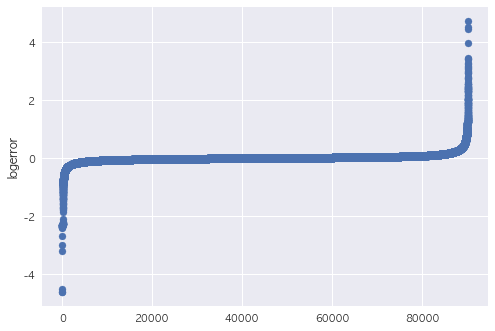

In [29]:
plt.scatter(x = train.index, y = np.sort(train.logerror.values))
plt.ylabel('logerror', fontsize = 12)
plt.show()

## 1-4. logerror컬럼에 대해 distplot을 그려보고 (bins=50)

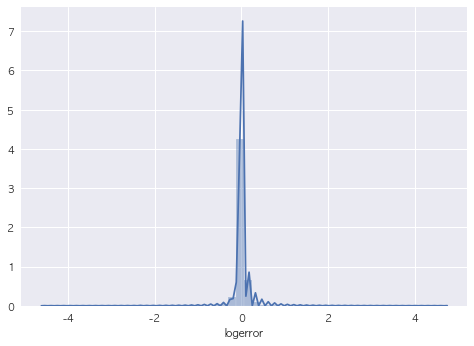

In [33]:
sns.distplot(train.logerror)
plt.show()

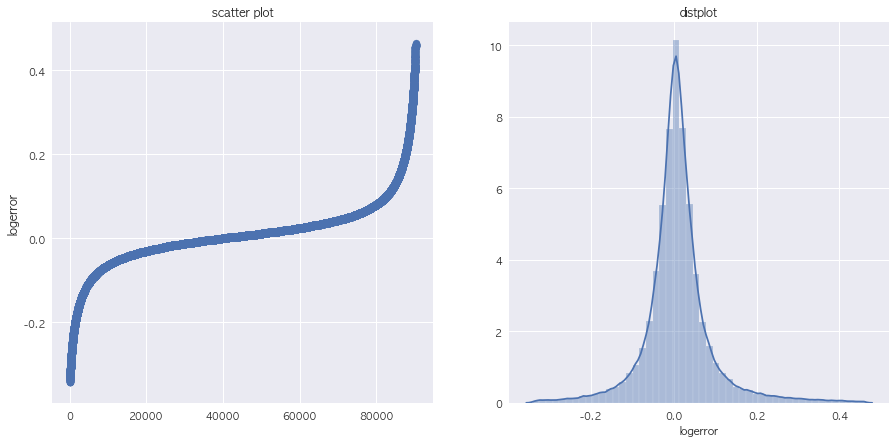

In [56]:
# 상위 1%와 하위 1% 제외 scatter plot과 distplot
f, ax = plt.subplots(1, 2, figsize = (15, 7))
temp = train.loc[(train['logerror'] < train.logerror.quantile(0.99)) & (train['logerror'] > train.logerror.quantile(0.01)), 'logerror']
ax[0].scatter(x = temp.index, y = np.sort(temp.values))
ax[0].set_ylabel('logerror', fontsize = 12)
ax[0].set_title('scatter plot')
sns.distplot(temp, ax = ax[1])
ax[1].set_title('distplot')
plt.show()

## 1-5. props 데이터에 대한 NaN값을 확인하시오 

In [60]:
# 약 290만개, 58개 피처
prop.shape

(2985217, 58)

In [61]:
# Null 값이 너무많은데..?
prop.isnull().sum()

parcelid                              0
airconditioningtypeid           2173698
architecturalstyletypeid        2979156
basementsqft                    2983589
bathroomcnt                       11462
bedroomcnt                        11450
buildingclasstypeid             2972588
buildingqualitytypeid           1046729
calculatedbathnbr                128912
decktypeid                      2968121
finishedfloor1squarefeet        2782500
calculatedfinishedsquarefeet      55565
finishedsquarefeet12             276033
finishedsquarefeet13            2977545
finishedsquarefeet15            2794419
finishedsquarefeet50            2782500
finishedsquarefeet6             2963216
fips                              11437
fireplacecnt                    2672580
fullbathcnt                      128912
garagecarcnt                    2101950
garagetotalsqft                 2101950
hashottuborspa                  2916203
heatingorsystemtypeid           1178816
latitude                          11437


# 2. 데이터 탐색

## 2-1. train 데이터와 props데이터를 left join merge하되 “parcelid”를 기준으로 하시오

In [68]:
train['parcelid']

0        11016594
1        14366692
2        12098116
3        12643413
4        14432541
           ...   
90270    10774160
90271    12046695
90272    12995401
90273    11402105
90274    12566293
Name: parcelid, Length: 90275, dtype: int64

In [69]:
prop['parcelid']

0           10754147
1           10759547
2           10843547
3           10859147
4           10879947
             ...    
2985212    168176230
2985213     14273630
2985214    168040630
2985215    168040830
2985216    168040430
Name: parcelid, Length: 2985217, dtype: int32

In [85]:
train = train.merge(prop, on = 'parcelid', how = 'left')

In [111]:
train.shape

(90275, 60)

## 2-2. 만들어진 데이터에 대해 데이터 타입을 재구조화 하시오 

In [115]:
columns = ['airconditioningtypeid', 'architecturalstyletypeid','buildingclasstypeid'
       , 'decktypeid', 'hashottuborspa','heatingorsystemtypeid'
       ,'propertyzoningdesc','propertylandusetypeid','propertycountylandusecode','regionidcity','regionidcounty'
       ,'regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid', 'yearbuilt'
       ,'fireplaceflag','assessmentyear','taxdelinquencyyear','taxdelinquencyflag']

In [86]:
for c in columns:
    train[c] = train[c].astype(object)

In [116]:
for c in columns:
    prop[c] = prop[c].astype(object)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      90275 non-null  int64         
 1   logerror                      90275 non-null  float64       
 2   transactiondate               90275 non-null  datetime64[ns]
 3   airconditioningtypeid         28781 non-null  object        
 4   architecturalstyletypeid      261 non-null    object        
 5   basementsqft                  43 non-null     float16       
 6   bathroomcnt                   90275 non-null  float16       
 7   bedroomcnt                    90275 non-null  float16       
 8   buildingclasstypeid           16 non-null     object        
 9   buildingqualitytypeid         57364 non-null  float16       
 10  calculatedbathnbr             89093 non-null  float16       
 11  decktypeid                  

## 2-3. 만들어진 merge data에 대해 상관 heatmap을 그리고 상관계수가 없는 컬럼은 props 데이터에서 삭제하시오.

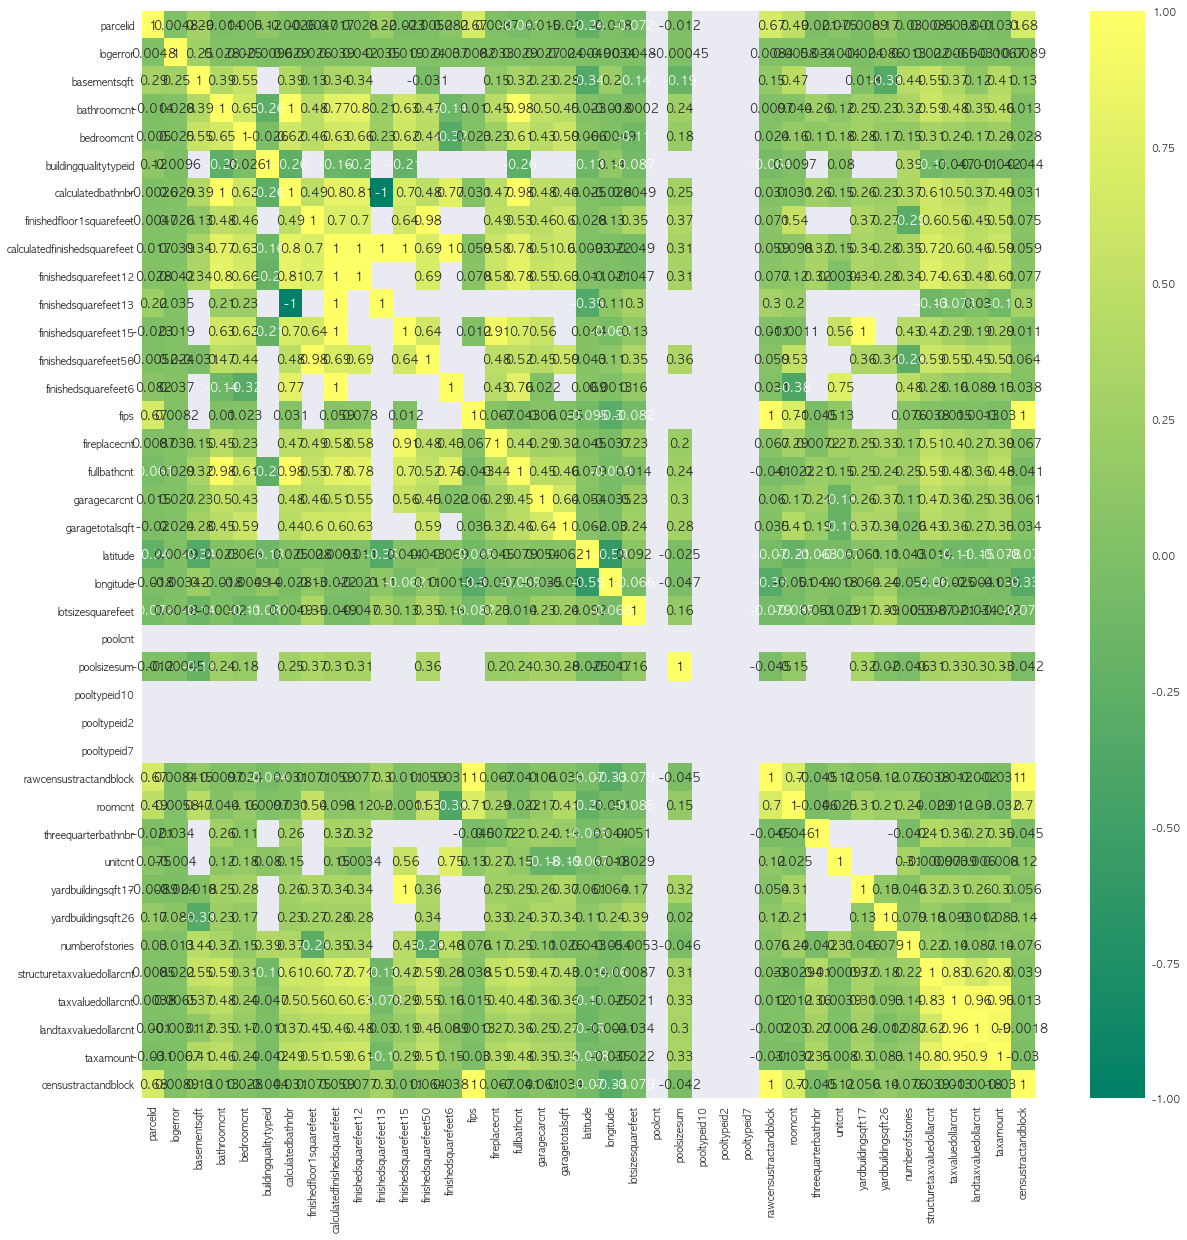

In [93]:
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(), annot = True, cmap = 'summer')
plt.show()

In [102]:
# 상관계수가 없는 비율
(train.corr().isnull().sum() / 39).sort_values(ascending = False)

pooltypeid10                   1.000
pooltypeid7                    1.000
poolcnt                        1.000
pooltypeid2                    1.000
finishedsquarefeet13           0.564
buildingqualitytypeid          0.436
finishedsquarefeet6            0.436
threequarterbathnbr            0.385
fips                           0.333
unitcnt                        0.308
finishedsquarefeet15           0.308
basementsqft                   0.282
poolsizesum                    0.282
yardbuildingsqft26             0.282
yardbuildingsqft17             0.256
finishedsquarefeet50           0.256
finishedfloor1squarefeet       0.256
garagetotalsqft                0.205
finishedsquarefeet12           0.179
garagecarcnt                   0.154
fireplacecnt                   0.154
numberofstories                0.128
fullbathcnt                    0.128
calculatedbathnbr              0.103
calculatedfinishedsquarefeet   0.103
logerror                       0.103
bathroomcnt                    0.103
b

In [113]:
columns = list((train.corr().isnull().sum() / 39).sort_values(ascending = False).index[:4])
train = train.drop(columns, axis = 1)
prop = prop.drop(columns, axis = 1)

## 2-4. 만들어진 merge data에 대해 결측값의 비율이 99%가 넘으면 삭제하시오.

In [130]:
# 결측치 비율이 90 넘는 것 -> 삭제
columns = list((train.isnull().sum() / train.shape[0]).sort_values(ascending = False).index[:18])

In [131]:
train = train.drop(columns, axis = 1)
prop = prop.drop(columns, axis = 1)

## 2-5. merge data의 nan값을 임시로 -999로 채우고 유니크한 값을 세시오 센 후, 각 카운트가 5개 이하인 컬럼에 대해 countplot을 그리고 props 데이터에서 제거할 지 결정하시오.


In [268]:
train = train.fillna(-999)

In [259]:
prop = prop.fillna(-999)

In [139]:
train.nunique().sort_values()[:7]

assessmentyear           1
fips                     3
regionidcounty           3
numberofstories          4
threequarterbathnbr      4
fireplacecnt             5
airconditioningtypeid    6
dtype: int64

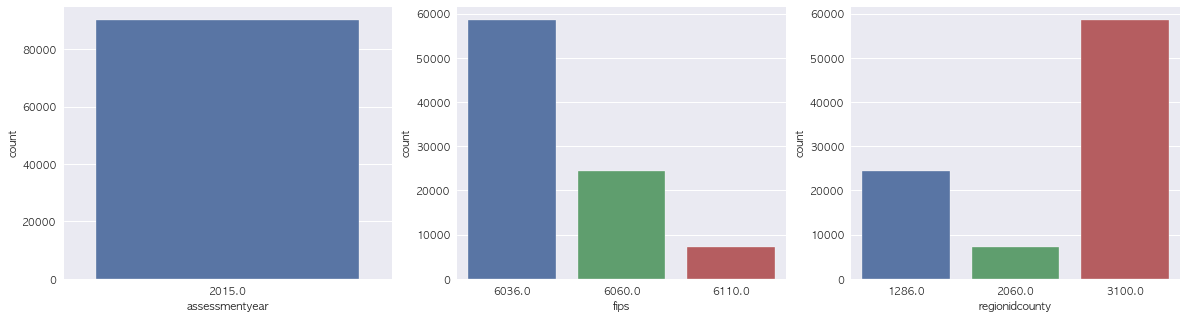

In [173]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, c in enumerate(train.nunique().sort_values()[:7].index[:3]):
    sns.countplot(train[c], ax = ax[i])

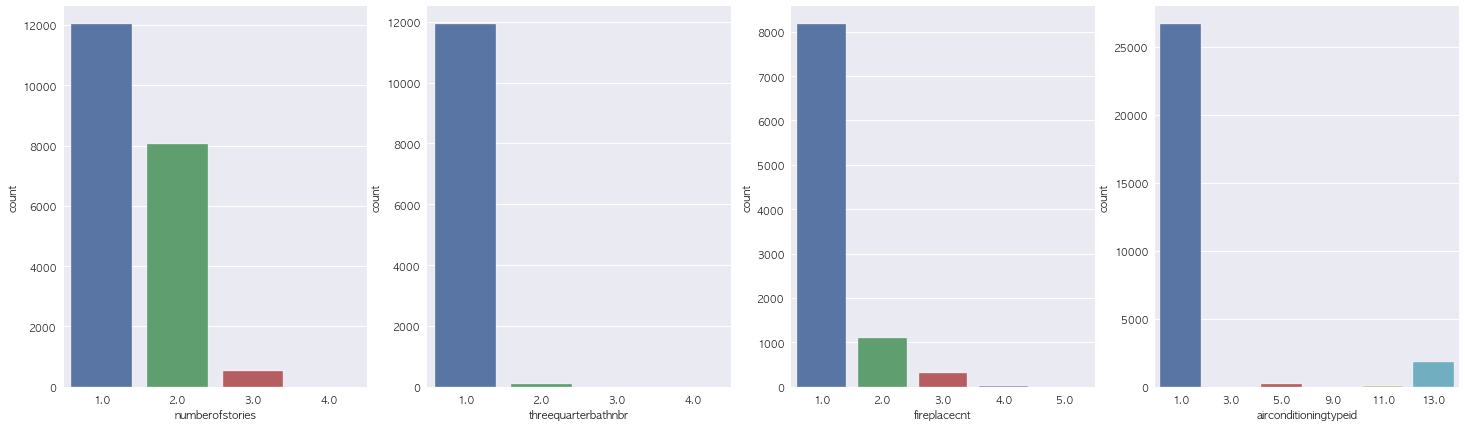

In [182]:
f, ax = plt.subplots(1, 4, figsize=(25, 7))
for i, c in enumerate(train.nunique().sort_values()[:7].index[3:7]):
    sns.countplot(train[c], ax = ax[i])

# 3. EDA

## 3-1. finishedsquarefeet12, calculatedfinishedsquarefeet, taxamount 컬럼에 대해 jointplot을그리시오 

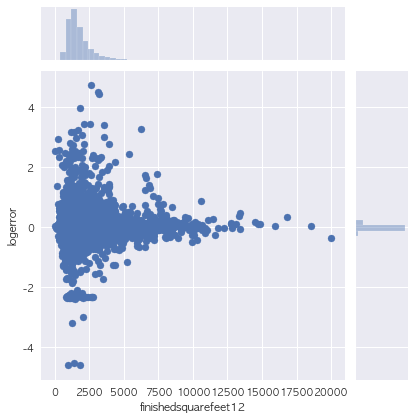

In [198]:
sns.jointplot(x = 'finishedsquarefeet12', y = 'logerror', data = train)
plt.show()

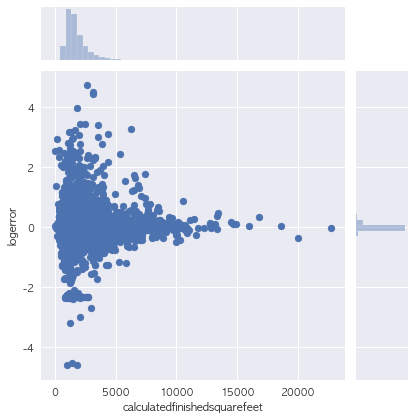

In [190]:
sns.jointplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data = train)
plt.show()

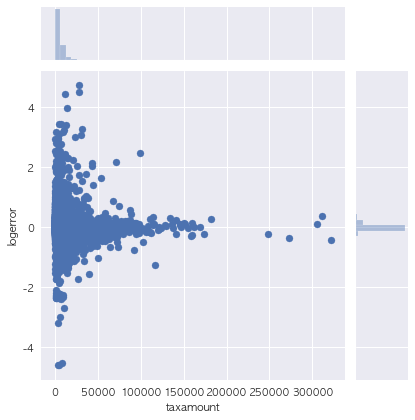

In [199]:
sns.jointplot(x = 'taxamount', y = 'logerror', data = train)
plt.show()

## 3-2. bathroomcnt, bedroomcnt에 대해 카운트 플랏을 그리시오 



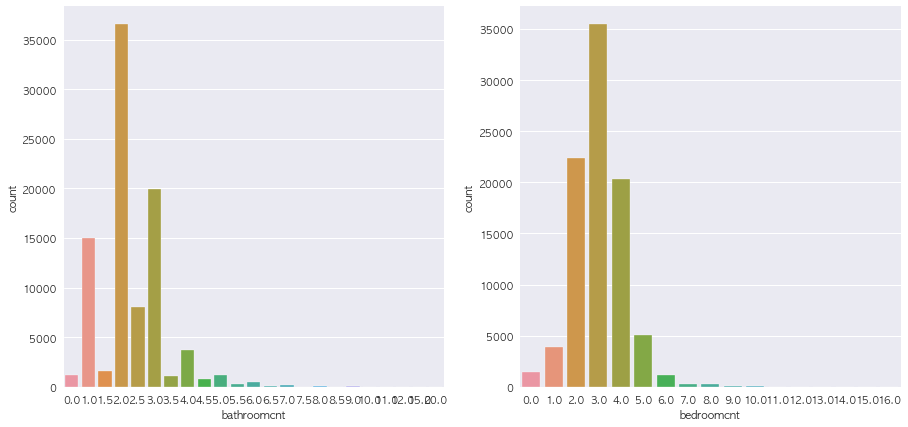

In [205]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
sns.countplot(train.bathroomcnt, ax = ax[0])
sns.countplot(train.bedroomcnt, ax = ax[1])
plt.show()

## 3-3. bathroomcnt, bedroomcnt을 각 각 x축으로, log error를 y축으로 box plot을 그리시오 

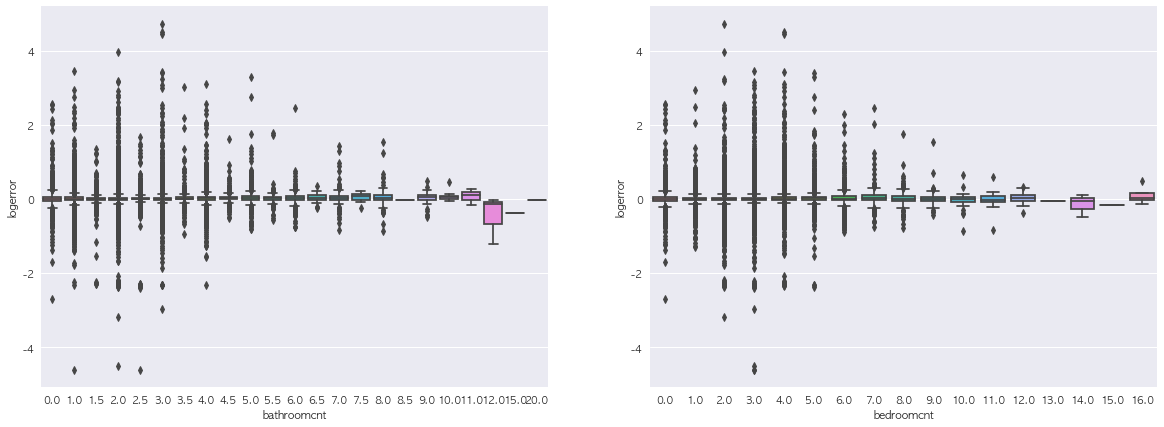

In [213]:
f, ax = plt.subplots(1, 2, figsize = (20, 7))
sns.boxplot(x = 'bathroomcnt', y = 'logerror', data = train, ax = ax[0])
sns.boxplot(x = 'bedroomcnt', y = 'logerror', data = train, ax = ax[1])
plt.show()

# 4. 피쳐 엔지니어링

## 4-1. props에서 해당 변수를 제거하시오

In [218]:
columns = ['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'censustractandblock']

In [220]:
train = train.drop(columns, axis = 1)
prop = prop.drop(columns, axis = 1)

## 4-2. yearbuilt컬럼에서 2016 – yearbuilt를 계산해 새로운 컬럼을 만들고 기존 yearbuilt를 삭제하시오

In [225]:
train['yearbuilt'] = 2016 - train['yearbuilt']
prop['yearbuilt'] = 2016 - prop['yearbuilt']

## 4-3. latitude와 longitude컬럼을 PCA로 2가지 주성분으로 나타내고 기존 컬럼을 삭제하시오

In [227]:
train[['latitude', 'longitude']]

,latitude,longitude
0,34280992.000,-118488536.000
1,33668120.000,-117677552.000
2,34136312.000,-118175032.000
3,33755800.000,-118309000.000
4,33485644.000,-117700232.000
...,...,...
90270,34203000.000,-118562000.000
90271,34198744.000,-118224848.000
90272,34075656.000,-118025536.000
90273,33963900.000,-118367000.000


In [228]:
from sklearn.cluster import MiniBatchKMeans

In [260]:
coords = np.vstack((train[['latitude', 'longitude']].values, prop[['latitude', 'longitude']].values))

In [261]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (train, prop):
    df.loc[:, 'location'] = kmeans.predict(df[['latitude', 'longitude']])

# 5. 모델링

In [276]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [278]:
X = train.drop(['parcelid', 'logerror', 'transactiondate'], axis = 1)
y = train['logerror']

In [280]:
test_id = prop['parcelid']
test = prop.drop('parcelid', axis = 1)

In [285]:
pd.get_dummies(X)

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedsquarefeet12,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,...,propertyzoningdesc_WVRPD112U*,propertyzoningdesc_WVRPD12U*,propertyzoningdesc_WVRPD12U-R,propertyzoningdesc_WVRPD17U*,propertyzoningdesc_WVRPD18U*,propertyzoningdesc_WVRPD40000,propertyzoningdesc_WVRPD4OOOO,propertyzoningdesc_WVRPD56*,propertyzoningdesc_WVRR,propertyzoningdesc_WVRR1-RPD1
0,1.000,2.000,3.000,4.000,1684.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0
1,-999.000,3.500,4.000,-999.000,2263.000,6060.000,-999.000,2.000,468.000,-999.000,...,0,0,0,0,0,0,0,0,0,0
2,1.000,3.000,2.000,4.000,2217.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0
3,1.000,2.000,2.000,4.000,839.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0
4,-999.000,2.500,4.000,-999.000,2283.000,6060.000,-999.000,2.000,598.000,-999.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,1.000,1.000,1.000,4.000,653.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0
90271,-999.000,3.000,3.000,4.000,2856.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0
90272,-999.000,2.000,4.000,7.000,-999.000,6036.000,-999.000,-999.000,-999.000,-999.000,...,0,0,0,0,0,0,0,0,0,0
90273,-999.000,2.000,2.000,4.000,1034.000,6036.000,-999.000,-999.000,-999.000,2.000,...,0,0,0,0,0,0,0,0,0,0


In [305]:
X = pd.get_dummies(X.drop(['propertyzoningdesc', 'propertycountylandusecode'], axis = 1))
test = pd.get_dummies(test.drop(['propertyzoningdesc', 'propertycountylandusecode'], axis = 1))

In [317]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [318]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((72220, 30), (18055, 30), (72220,), (18055,))

In [319]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [320]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'mae', 'objective': 'reg:linear'}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [323]:
model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.259714	valid-mae:0.261062
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.067176	valid-mae:0.069527
[20]	train-mae:0.06629	valid-mae:0.070229
[30]	train-mae:0.065638	valid-mae:0.071496
[40]	train-mae:0.064896	valid-mae:0.072052
[50]	train-mae:0.06415	valid-mae:0.072952
[60]	train-mae:0.063557	valid-mae:0.073594
[70]	train-mae:0.062916	valid-mae:0.074349
[80]	train-mae:0.062275	valid-mae:0.074844
[90]	train-mae:0.06164	valid-mae:0.075445
[100]	train-mae:0.060951	valid-mae:0.076043
Stopping. Best iteration:
[8]	train-mae:0.067386	valid-mae:0.069341



# 5-1. Submission

In [326]:
dtest = xgb.DMatrix(test)

In [327]:
y_pred = model.predict(dtest)

In [83]:
sub = pd.read_csv(os.path.join('..', 'W05', 'sample_submission.csv'))

In [330]:
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_pred

In [332]:
sub.to_csv('submission01.csv', index = False)